In [1]:
import numpy as np
from time import strftime
from os import environ

from scipy.optimize import fmin
from scipy.interpolate import interp1d

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def find_files_like(datapath, startswith, endswith='.npz'):
    from os import listdir
    
    # look for file in folder `datapath` that starts with `startswith`
    filename = []
    for file in listdir(datapath):
        if file.startswith(startswith) and file.endswith(endswith):
            filename.append(file)
    
    return filename

In [3]:
def read_threshold_file(folder, startswith='ThresholdData_ALLThreshold_', endswith='.xlsx'):
    import pandas as pd
    
    if not folder.endswith('/'):
        folder += '/'
        
    files = find_files_like(folder, startswith, endswith)
    if not files:
        return None
    else:
        file = files[0]
        print('- Reading file "' + file + '"')
        
    xl = pd.ExcelFile(folder + file)
    df = xl.parse(xl.sheet_names[0])  # assume Sheet 1
    assert 'electrode' in df.columns
    assert 'amp_th_0' in df.columns
    assert 'amp_th_1' in df.columns
    assert 'amp_th_2' in df.columns
    
    data = {}
    for e, a0, a1, a2 in zip(df['electrode'], df['amp_th_0'], df['amp_th_1'], df['amp_th_2']):
        data[e] = [a0, a1, a2]
    return data

In [4]:
def distance2threshold(el_dist):
    """Converts electrode distance (um) to threshold (uA)

    Based on linear regression of data presented in Fig. 7b of
    deBalthasar et al. (2008). Relationship is linear in log-log space.
    """
    slope = 1.5863261730600329
    intercept = -4.2496180725811659
    if el_dist > 0:
        return np.exp(np.log(el_dist) * slope + intercept)
    else:
        return np.exp(intercept)


def fit_plane(x, implant, data):
    err = []
    for e in implant:
        zi = x[0] * e.x_center + x[1] * e.y_center + x[2]
        ti = distance2threshold(zi)
        
        for d in data[e.name]:
            err.append((ti - d) ** 2)

    return np.mean(err)


x_d2t = np.linspace(0, 1000, 100)
y_d2t = np.array([distance2threshold(x) for x in x_d2t])
threshold2distance = interp1d(y_d2t, x_d2t, fill_value='extrapolate')

In [5]:
def update_implant_distance(implant, folder, verbose=True):
    # Read threshold file to find threshold currents for each electrode
    data = read_threshold_file(folder)
    if data is None:
        print('Could not find threshold file')
        return
    
    # Give each electrode a threshold value
    for e in implant:
        e.threshold = np.mean(data[e.name])
    
    # Fit plane to threshold data
    xopt = fmin(func=fit_plane, x0=[-1, -1, 500], args=(implant, data))
    if verbose:
        print(xopt)
    
    # Update electrode height
    xx = [e.x_center for e in implant]
    yy = [e.y_center for e in implant]
    zz = np.array([xopt[0] * x + xopt[1] * y + xopt[2] for x, y in zip(xx, yy)])
    for electrode, height in zip(implant, zz):
        electrode.set_height(height)
    
    if verbose:
        print('Updated electrode-retina distances:')
        print([e.h_nfl for e in implant])

In [6]:
def plot_implant_distance(implant, threshold_data=None):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.gca(projection='3d')

    if threshold_data is not None:
        for e in implant:
            for d in threshold_data[e.name]:
                ax.plot([e.x_center, e.x_center], [e.y_center, e.y_center], [0, d], 'k')
                ax.scatter(e.x_center, e.y_center, d, 'k')

    # xx, yy = np.meshgrid([e.x_center for e in argus], [e.y_center for e in argus])
    xx = [e.x_center for e in implant]
    yy = [e.y_center for e in implant]
    zz = [e.h_nfl for e in implant]

    ax.scatter(xx, yy, zz, linewidths=6)
    ax.scatter(xx, yy, [distance2threshold(z) for z in zz], linewidths=4)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    fig.savefig(exp_params['save_dir'] + 'array_height.eps')

In [7]:
def setup_model(exp_params):
    model = dict()
    model['tm'] = ec2b.TemporalModel(tsample=exp_params['tsample'])
    
    # Create an Argus I array with old labeling
    argus = e2cm.ArgusI(x_center=-675, y_center=48.5, h=100,
                        rot=np.deg2rad(43.53), use_legacy_names=True)

    # Try to set heights from threshold file
    update_implant_distance(argus, exp_params['data_dir'])
#     for e in argus:
#         e.threshold = distance2threshold(e.h_nfl)
#         e.threshold = 15
        
    model['implant'] = argus
    
    # Create a retina that fits the implant
    round_to = 500  # round to nearest (microns)
    cspread = 1000  # expected current spread (microns)
    xs = [a.x_center for a in argus]
    ys = [a.y_center for a in argus]
    xlo = np.floor((np.min(xs) - cspread) / round_to) * round_to
    xhi = np.ceil((np.max(xs) + cspread) / round_to) * round_to
    ylo = np.floor((np.min(ys) - cspread) / round_to) * round_to
    yhi = np.ceil((np.max(ys) + cspread) / round_to) * round_to
    model['retina'] = e2cm.Retina(sampling=exp_params['r_sampling'],
                                  xlo=xlo, xhi=xhi, ylo=ylo, yhi=yhi,
                                  axon_lambda=exp_params['axon_lambda'],
                                  rot=exp_params['r_rot_deg']*np.pi/180,
                                  loadpath=exp_params['save_dir'])
    # TODO: loadpath is also a savepath...maybe rename to datapath?
    
    # Plot axon bundles (plot every 5th for the sake of visualization)
    fig, ax = plt.subplots(1)
    ax.set_axis_bgcolor('black')
    ax.plot(model['retina'].jan_x[:, ::5], -model['retina'].jan_y[:, ::5],
            c=(0.5, 1, 0.5))

    # Plot location of implant on top of axon bundles
    for e in model['implant']:
        ax.text(e2cm.micron2deg(e.x_center + 10), -e2cm.micron2deg(e.y_center + 5),
                e.name, color='white', size='x-large')
        ax.plot(e2cm.micron2deg(e.x_center), -e2cm.micron2deg(e.y_center), 'ow',
                markersize=np.sqrt(e.radius))
    ax.set_aspect('equal')
    ax.set_xlim(-15, 15)
    ax.set_xlabel('visual angle (deg)')
    ax.set_ylim(-10, 10)
    ax.set_ylabel('visual angle (deg)')
    ax.set_title('Image flipped (upper retina = upper visual field)')
    fig.savefig(exp_params['save_dir'] + 'implant.eps')
    
    return model

In [8]:
def run_condition(idx_cond, exp_params, model):
    """Run a single condition of the Horsager experiment"""
    
    if idx_cond != 1:
        raise ValueError('Unknown idx_cond ' + str(idx_cond))
    
    name_E1 = exp_params['name_E1']
    name_E2 = exp_params['name_E2']
    assert name_E1 is not None or name_E2 is not None
    
    # At least one electrode must be different from None
    E1 = model['implant'][name_E1]
    E2 = model['implant'][name_E2]
    assert E1 is not None or E2 is not None
    
    # Set up currents
    amp_E1 = amp_E2 = np.array([0])
    if E1 is not None:
        amp_E1 = E1.threshold * np.array([1.25, 1.5, 2.0, 3.0, 4.0])
    if E2 is not None:
        amp_E2 = E2.threshold * np.array([1.25, 1.5, 2.0, 3.0, 4.0])
#     amp_E1 = exp_params['amp_thresh'] + np.array([30, 100, 200])
#     amp_E2 = exp_params['amp_thresh'] + np.array([30, 100, 200])
        
    data = dict()
    data['frames'] = []
    data['amp_E1'] = []
    data['amp_E2'] = []
    print ("- Condition %d" % idx_cond)
    for a1 in amp_E1:
        for a2 in amp_E2:
            # generate list of pulse trains
            pt_e1 = get_pulse_train(a1, tsample=exp_params['tsample'])
            pt_e2 = get_pulse_train(a2, tsample=exp_params['tsample'])
            if name_E1 is None:
                a1 = None
                pt = {name_E2: pt_e2}
            elif name_E2 is None:
                a2 = None
                pt = {name_E1: pt_e1}
            else:
                pt = {name_E1: pt_e1, name_E2: pt_e2}
                
            resp = ec2b.pulse2percept(pt, model['implant'], model['tm'], model['retina'],
                                      use_ecs=exp_params['use_ecs'], tol=exp_params['tol'],
                                      n_jobs=8)

            # Find brightest frame
            brightest = ec2b.get_brightest_frame(resp)

            # Save data
            data['frames'].append(brightest)
            data['amp_E1'].append(a1)
            data['amp_E2'].append(a2)
            
    return data

In [9]:
def run_experiment(exp_params, model):
    import os
    
    exp_params['date'] = strftime("%Y-%m-%d")
    print('Experiment: %s %s, %s' % (exp_params['name'], exp_params['name_E1'], exp_params['name_E2']))
    print('- Start time: %s %s' % (exp_params['date'], strftime("%H:%M:%S")))
    
    # Create data dir if necessary
    datapath = exp_params['save_dir']
    if not datapath.endswith('/'):
        datapath += '/'
    datapath += exp_params['date'] + '/'
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    
    # Create filename
    prefix = exp_params['name']
    electrodes = '%s_%s' % (exp_params['name_E1'], exp_params['name_E2'])
    suffix = '.npz'

    # Check if we ran this experiment already
    for file in os.listdir(datapath):
        if file.startswith(prefix + '_' + electrodes):
            if exp_params['overwrite']:
                print('File that starts with %s_%s already exists, overwrite' % (prefix, electrodes))
            else:
                print('File that starts with %s_%s already exists, skip' % (prefix, electrodes))
                return

    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_%s%s' % (datapath, prefix, electrodes, suffix)
    np.savez(filename, data=np.zeros(10))
    os.remove(filename)
    print('- File: %s' % filename)
    exp_params['filename'] = filename

    # Run all 5 conditions
    data = dict()
    for idx_cond in range(1):
        name_cond = 'cond' + str(idx_cond + 1)
        data[name_cond] = run_condition(idx_cond + 1, exp_params, model)

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)
    print('- End time: %s' % strftime("%Y-%m-%d %H:%M:%S"))

In [10]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(amp, tsample, delay_dur=0):
    freq = 20
    pulse_dur = 0.45/1000
    stim_dur = 0.1
    return e2cm.Psycho2Pulsetrain(tsample, freq=freq, amp=amp, dur=stim_dur, delay=delay_dur,
                                  pulse_dur=pulse_dur, interphase_dur=pulse_dur)

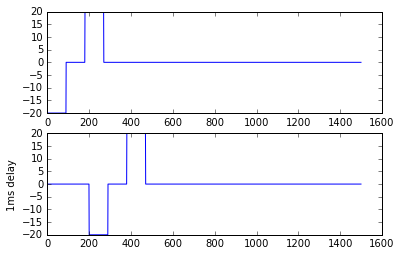

In [11]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 5e-6, 0).data[0:1500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 5e-6, 1/1000).data[0:1500])
plt.ylabel('1ms delay')

- Reading file "ThresholdData_ALLThreshold_20080625.xlsx"
Optimization terminated successfully.
         Current function value: 1081.881654
         Iterations: 139
         Function evaluations: 251
[ -1.00489071e-01   5.99667175e-02   1.52103528e+02]
Updated electrode-retina distances:
[390.71084067362074, 299.3851587813283, 208.05947688903581, 116.73379499674336, 370.12398656411506, 278.79830467182262, 187.47262277953013, 96.146940887237648, 349.53713245460943, 258.21145056231694, 166.88576867002445, 75.560086777731996, 328.9502783451037, 237.62459645281126, 146.2989145605188, 54.973232668226302]


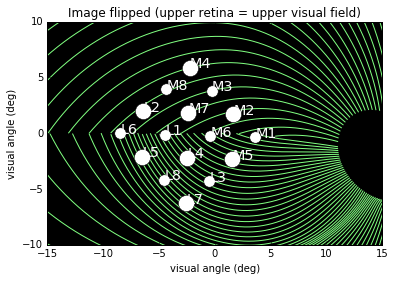

In [12]:
exp_params = dict()

# Subject name
exp_params['subject'] = 'TB'

# Date
exp_params['exp_date'] = '20080702'

# sampling step in seconds
exp_params['tsample'] = 0.005 / 1000

# whether to use effective current map (True) or current map (False)
exp_params['use_ecs'] = False

exp_params['axon_lambda'] = 2
exp_params['r_sampling'] = 100
exp_params['r_rot_deg'] = 0
exp_params['tol'] = 0.2

# Overwrite existing files
exp_params['overwrite'] = True

# where to find the data
exp_params['data_dir'] = '%s/shape/%s/%s' % (environ['SECOND_SIGHT_DATA'],
                                             exp_params['subject'],
                                             exp_params['exp_date'])
# where to save the data (relative path)
exp_params['save_dir'] = '%s/data/shape/%s/%s/' % (environ['HOME'],
                                                   exp_params['subject'],
                                                   exp_params['exp_date'])

# Experiment name
exp_params['name'] = 'lambda%.1f' % exp_params['axon_lambda']

model = setup_model(exp_params)

- Reading file "ThresholdData_ALLThreshold_20080625.xlsx"


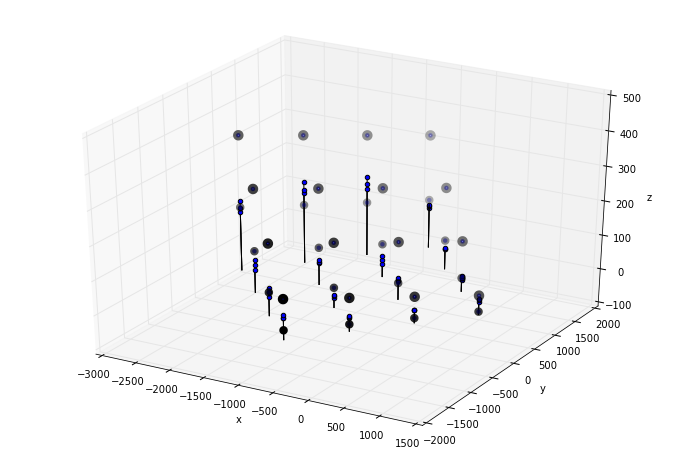

In [13]:
plot_implant_distance(model['implant'], read_threshold_file(exp_params['data_dir']))

In [14]:
# different electrode pairs
name_E1 = ['L1', 'L1', 'L2', 'L2', 'L2', 'M2', 'M3', 'M3', 'M4', 'M4']
name_E2 = [None, 'M2', None, 'M3', 'M4', None, None, 'L2', None, 'L2']

name_E1 = ['L1', 'L4', 'M1', 'M3', 'M4', 'M6', 'M7', 'M8']
name_E2 = [None, None, None, None, None, None, None, None]



for name1, name2 in zip(name_E1, name_E2):
    exp_params['name_E1'] = name1
    exp_params['name_E2'] = name2
    
    t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
    print('- Experiment took %.1f s' % t_exe.best)

Experiment: lambda2.0 L1, None
- Start time: 2017-01-22 23:55:08
File that starts with lambda2.0_L1_None already exists, overwrite
- File: /home/mbeyeler/data/shape/TB/20080702/2017-01-22/lambda2.0_L1_None.npz
- Condition 1
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
- Results saved to /home/mbeyeler/data/shape/TB/20080702/2017-01-22/lambda2.0_L1_None.npz
- End time: 2017-01-22 23:56:07
- Experiment took 58.8 s
Experiment: lambda2.0 L4, None
- Start time: 2017-01-22 23:56:07
File that starts with lambda2.0_L4_None already exists, overwrite
- File: /home/mbeyeler/data/shape/TB/20080702/2017-01-22/lambda2.0_L4_None.npz
- Condition 1
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
tol=0.200000, 1505/3721 pixels
- Results saved to /home/mbeyeler/data/shape/TB/20080702/2017-01-22/lambda2.0_L4_None.npz
- End